In [1]:
import json
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale
import slugify

# math packages:
import pandas as pd
import numpy as np
from math import pi
import scipy.stats as stats

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# images and display
from IPython.display import Markdown as md
from IPython import display


header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

## Plastock - Iqaasl

### Comparaison de la taille des lieux d'échantillonnage

### Mètres carrés

In [2]:
# plastock data
plastock = pd.read_csv("data/20230314macro.csv", sep=";", encoding="ISO-8859-3")
p_beaches = pd.read_csv("data/asl_beaches2.csv")
# iqaasl data
iq_dims = pd.read_csv("data/corrected_dims.csv")
iqaasl = pd.read_csv("data/lac_leman_iqaasl.csv")

# plastock survey data of interest
pstck_cols = ['Lieu', 'Aire','Position', 'Date', 'Code', 'Quantité']
pstck_rename = {"Lieu":"location", "Aire":"area", "Date":"date", "Code":"code", "Quantité":"quantity", "Position":"position"}
pstck =  plastock[pstck_cols]
pstck = pstck.rename(columns=pstck_rename)

# the surveys were separated into two zones for plastock
# we want to compare the total of the surveys, so the zones at each
# location and survey need to be combined
pstck_q = pstck.groupby(["location", "date", "code"], as_index=False).quantity.sum()

# the length of the survey is not included in the plastock survey data
# it needs to be attached to the survey reults, this information is available
# in the beaches file
pbl = p_beaches[["location", "length"]].drop_duplicates(["location", "length"]).set_index("location")

# the dimensional data was taken once per survey
# remove the duplicate values by date and location
pstck_ndup = pstck.drop_duplicates(["location", "date","area"])
# combine the areas by date and location
pstck_ta = pstck_ndup.groupby(["location", "date"]).area.sum()
pstck = pstck_q.merge(pstck_ta, on=["location", "date"])

# the location names in asl_beaches does not match the names in 20230314macro.csv
# the names in the asl_beaches file were changed previously
# they need to be changed back to match the new survey data
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# the differences are capitalizations and hyphenations
renames = {x: p_names[i] for i, x in enumerate(pstock_names)}
pstck["location"] = pstck.location.apply(lambda x: renames[x])

# add the length
pstck["length"] = pstck.location.apply(lambda x: pbl.loc[x].length)
pstck["project"] = "plastock"
pstck["date"] = pd.to_datetime(pstck["date"], format="%d.%m.%Y")

pstck["doy"] = pstck["date"].dt.dayofyear
pstck["date"] = pstck["date"].dt.date

# the columns of interest
survey_columns = [
    "location",
    "date",
    "code",
    "length",
    "area",
    "quantity",
    "project",
    "doy"
]

pstck = pstck[survey_columns]
# there are aggregations that need to be made to the plastock data. The fragemented foams
# and fragmented plastics are consolidated into one group of codes. The plastic caps are consolidated
# as per the intend of the ASL and the recomendation from the IQAASL report.    
gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
columns = ['location', 'date',  'area', 'length','project', "doy"]
operations = {"quantity":"sum"}

# separate the codes of interest by group from the data frame and add the replacement value
pstck_gfrags = pstck[pstck.code.isin(plasticpcs)].groupby(columns, as_index=False).agg(operations)
pstck_gfoam = pstck[pstck.code.isin(gfoam)].groupby(columns, as_index=False).agg(operations)
pstck_gcaps = pstck[pstck.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)

pstck_gcaps["code"] = "Gcaps"
pstck_gfoam["code"] = "Gfoam"
pstck_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
pstck_no_frags = pstck[~pstck.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# formatted plastock data
pstck = pd.concat([pstck_no_frags, pstck_gfrags, pstck_gfoam, pstck_gcaps])

# zero is not accounted for in the plastock data
# this is essential for computing the median and average
# values. The fail rate can not be calculated with out it
# 1. collect all the codes that were identified in plastock
codes = pstck.code.unique()

# 2 make a dataframe of all possible codes and give them a
# quantity of zero
code_zero = pd.DataFrame({"code":codes})
code_zero["quantity"] = 0

# 3. collect all the unique date and location pairs
dates = pstck[['date', 'location']].drop_duplicates()

def add_zeroes(data, dates, code_zero):
    
    some_zeroes = []
    for apair in dates.values:
        # collect the results from one survey
        d = data[(data.location == apair[1])&(data["date"] == apair[0])]
        # collect the codes that were identified in the current survey
        codes_with_vals = d.code.unique()
        # identify the codes that were not identified
        codes_with_no_vals = [x for x in code_zero.code.unique() if x not in codes_with_vals]
        # collect the area and length for the current survey
        area_length = d[["area", "length"]].drop_duplicates(["area", "length"]).reset_index()
        # add the area, length, location, date and project to
        # to the dataframe of codes and zeroes
        code_zero["area"] = area_length.loc[0, "area"]
        code_zero["length"] = area_length.loc[0, "length"]
        code_zero["date"] = apair[0]
        code_zero["location"] = apair[1]
        code_zero["project"] = "plastock"
        # keep only the codes that were not indentified in the survey
        test_no_vals = code_zero[code_zero.code.isin(codes_with_no_vals)]
        # add the resulting df to the list
        some_zeroes.append(test_no_vals)
    return some_zeroes

# collect the zero values
zeroes =  add_zeroes(pstck, dates, code_zero)
# add them to the existing survey results
pstk = pd.concat([pstck, *zeroes], axis=0)

# IQAASL data
# only locations on lac leman
iq_locations = iqaasl.location.unique()
iq_d = iq_dims[iq_dims.location.isin(iq_locations)]

# there are three surveys that do not have length or area data:
# two at quai-maria-belgia and one at baby-plage-geneva
# the average value of the preceeding surveys will be used
qmb = iq_d[(iq_d.location == "quai-maria-belgia") & (iq_d.area > 0)].agg({"length":"mean", "area":"mean"})
bp = iq_d[(iq_d.location == "baby-plage-geneva") & (iq_d.area > 0)].agg({"length":"mean", "area":"mean"})

# separate the surveys with no dimensional data
qmb_0 = iq_d[(iq_d.location == "quai-maria-belgia") & (iq_d.area == 0)]
bp_0 = iq_d[(iq_d.location == "baby-plage-geneva") & (iq_d.area == 0)]

# add the derived values
qmb_0.loc[:, "area"] = qmb.area
qmb_0.loc[:, "length"] = qmb.length
bp_0.loc[:, "area"] = bp.area
bp_0.loc[:, "length"] = bp.length

# merge the corrections with the original data
# minus the records with no diemensional data
iqd = iq_d[(iq_d.area > 0)]
iqd = pd.concat([iqd, qmb_0, bp_0], axis=0)
iqd_la = iqd[["loc_date", "area"]].set_index("loc_date")

iqaasl["project"] = "iqaasl"
iqaasl["area"] = iqaasl.loc_date.apply(lambda x: iqd_la.loc[x].area)
iqa = iqaasl.copy()
iqa["date"] = pd.to_datetime(iqa["date"])
iqa["doy"] = iqa["date"].dt.dayofyear
iqa["date"] = iqa["date"].dt.date
iqa = iqa[survey_columns].copy()
iqa = iqa[iqa.code.isin(codes)]

# make gcaps, gfrags and foams are ready made
iqaasl_not_caps = iqa[~iqa.code.isin(Gcaps)].copy()
iqaasl_caps = iqa[iqa.code.isin(Gcaps)].groupby(columns, as_index=False).quantity.sum()
iqaasl_caps["code"] = "Gcaps"

# formatted iqaasl data
iqa = pd.concat([iqaasl_caps, iqaasl_not_caps])
combined = pd.concat([iqa,pstk], axis=0).reset_index(drop=True)
combined["loc_date"] = list(zip(combined.location, combined["date"]))
combined["pcs/m"] = combined["quantity"]/combined["length"]
combined["pcs/m²"] = combined["quantity"]/combined["area"]

combined_dt = combined.groupby(["loc_date", "location", "date", "doy", "project", "area", "length"], as_index=False).agg({"pcs/m":"sum", "pcs/m²":"sum"})


In [3]:
table_one = combined_dt.groupby("project")["area"].describe()
table_one.index.name = None
table_one.style.format(precision=2).set_table_styles(table_css_styles)

,count,mean,std,min,25%,50%,75%,max
iqaasl,98.00,209.44,166.09,3.00,117.75,159.00,260.25,942.00
plastock,95.00,430.13,409.10,16.00,231.00,340.00,496.00,1978.00


### Mètres linéaires

In [4]:
table_two = combined_dt.groupby("project")["length"].describe()
table_two.index.name = None
table_two.style.format(precision=2).set_table_styles(table_css_styles)

,count,mean,std,min,25%,50%,75%,max
iqaasl,98.00,48.05,27.86,5.00,29.25,43.63,56.00,157.00
plastock,95.00,69.17,32.03,18.00,45.00,66.00,91.00,125.00


## Comparaison des résultats:

Comparaison des résultats des deux projets : distribution des résultats de l'échantillon en pièces par mètre et en pièces par mètre au carré.

Seuls les objets identifiés dans PLASTOCK ont été pris en compte


### Pièces par mètre carré

In [5]:
table_three = combined_dt.groupby("project")["pcs/m²"].describe()
table_three.index.name = None
table_three.style.format(precision=2).set_table_styles(table_css_styles)

,count,mean,std,min,25%,50%,75%,max
iqaasl,98.00,2.27,4.25,0.03,0.43,0.98,2.16,32.33
plastock,95.00,0.69,0.67,0.03,0.20,0.52,0.88,3.64


### Pièces par mètre linéaire

In [6]:
table_four = combined_dt.groupby("project")["pcs/m"].describe()
table_four.index.name = None
table_four.style.format(precision=2).set_table_styles(table_css_styles)

,count,mean,std,min,25%,50%,75%,max
iqaasl,98.00,7.29,10.45,0.16,1.76,3.73,7.79,58.50
plastock,95.00,3.61,3.73,0.10,0.79,2.48,4.83,18.68


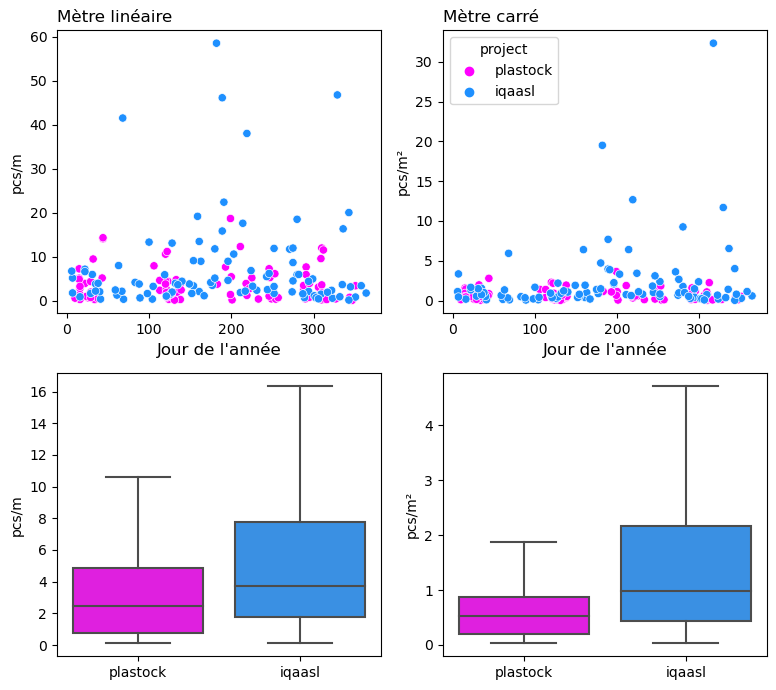

In [7]:
fig, ax = plt.subplots(2,2, figsize=(8, 7))
palette= {"iqaasl":"dodgerblue", "plastock":"magenta"}

sns.scatterplot(data=combined_dt, x="doy", y="pcs/m", ax=ax[0,0], hue="project", palette=palette)
sns.scatterplot(data=combined_dt, x="doy", y="pcs/m²", ax=ax[0,1], hue="project", palette=palette)
sns.boxplot(data=combined_dt, x='project', y="pcs/m", ax=ax[1,0], hue="project", palette=palette, showfliers=False, dodge=False)
sns.boxplot(data=combined_dt, x='project', y="pcs/m²", ax=ax[1,1], hue="project", palette=palette, showfliers=False, dodge=False)

ax[0,0].set_title("Mètre linéaire", fontsize=12, loc="left")
ax[0,1].set_title("Mètre carré", fontsize=12, loc="left")
ax[0,0].set_xlabel("Jour de l'année", fontsize=12)
ax[0,1].set_xlabel("Jour de l'année", fontsize=12)
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")
for anax in [ax[0,0], ax[1,0], ax[1,1]]:
    anax.get_legend().remove()

plt.tight_layout()
plt.show()

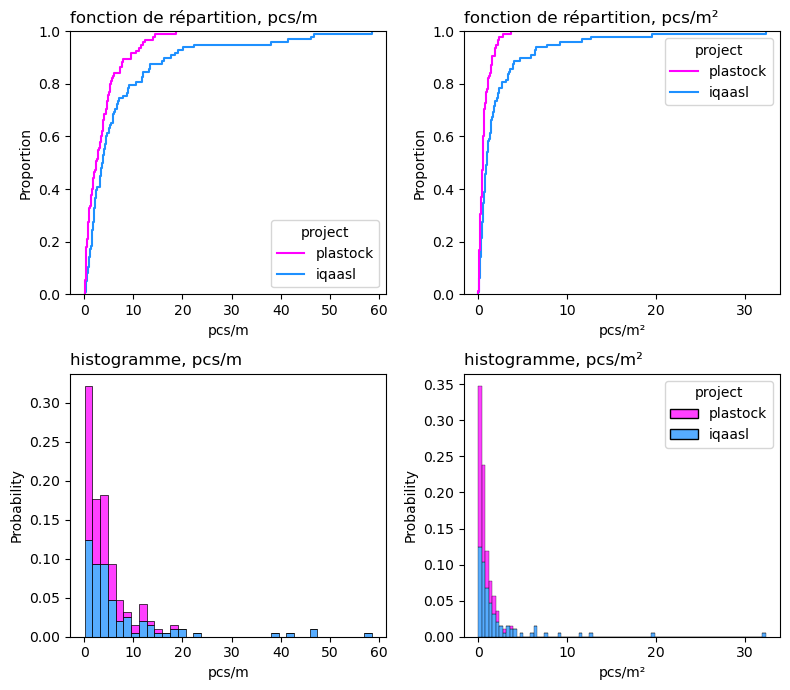

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7), sharex=False, sharey=False)

ax[0,0] = sns.ecdfplot(data=combined_dt, x="pcs/m", hue="project", palette=palette, ax=ax[0,0])
ax[1,0] = sns.histplot(data=combined_dt, x="pcs/m", hue="project", palette=palette, stat="probability", multiple="stack", ax=ax[1,0])
ax[0,1] = sns.ecdfplot(data=combined_dt, x="pcs/m²", hue="project", palette=palette, ax=ax[0,1])
ax[1,1] = sns.histplot(data=combined_dt, x="pcs/m²", hue="project", palette=palette, stat="probability", multiple="stack", ax=ax[1,1])

ax[0,0].set_title("fonction de répartition, pcs/m", loc="left")
ax[1,0].set_title("histogramme, pcs/m", loc="left")

ax[0,1].set_title("fonction de répartition, pcs/m²", loc="left")
ax[1,1].set_title("histogramme, pcs/m²", loc="left")

ax[1,0].get_legend().remove()
plt.tight_layout()

plt.show()

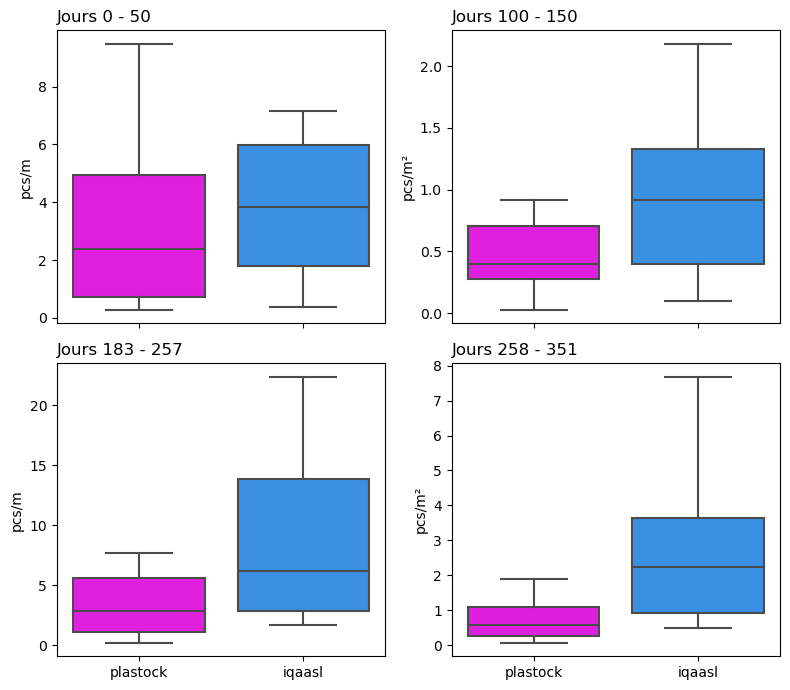

In [9]:

mask = (combined_dt.doy >=  0) & (combined_dt.doy <= 50)
q1 = combined_dt[mask]

mask_notin_pstock = (combined_dt.doy >50) & (combined_dt.doy < 100)
not_inpstck = combined_dt[mask_notin_pstock]

mask2 = (combined_dt.doy >= 100) & (combined_dt.doy <= 150)
q2 = combined_dt[mask2]

mask3 = (combined_dt.doy >= 183) & (combined_dt.doy <= 257)
q3 = combined_dt[mask3]

mask4 = (combined_dt.doy > 257) & (combined_dt.doy <= 351)
q4 = combined_dt[mask3]

merged_qs = pd.concat([q1, q2, q3, q4, not_inpstck], axis=0)

fig, ax = plt.subplots(2,2, figsize=(8, 7), sharex=True)
palette= {"iqaasl":"dodgerblue", "plastock":"magenta"}

sns.boxplot(data=q1, x="project", y="pcs/m", ax=ax[0,0], hue="project", palette=palette, showfliers=False, dodge=False)
sns.boxplot(data=q2, x="project", y="pcs/m²", ax=ax[0,1], hue="project", palette=palette, showfliers=False, dodge=False)
sns.boxplot(data=q3, x='project', y="pcs/m", ax=ax[1,0], hue="project", palette=palette, showfliers=False, dodge=False)
sns.boxplot(data=q4, x='project', y="pcs/m²", ax=ax[1,1], hue="project", palette=palette, showfliers=False, dodge=False)

ax[0,0].set_title("Jours 0 - 50", fontsize=12, loc="left")
ax[0,1].set_title("Jours 100 - 150", fontsize=12, loc="left")
ax[1,0].set_title("Jours 183 - 257", fontsize=12, loc="left")
ax[1,1].set_title("Jours 258 - 351", fontsize=12, loc="left")
for anax in [ax[0,1], ax[1,0], ax[1,1], ax[0,0]]:
    anax.get_legend().remove()
    anax.set_xlabel("")
    
plt.tight_layout()
plt.show()

### Jours d'échantillonnage par période de 12 mois

In [10]:
cov_pstock = combined_dt[combined_dt.project == "plastock"].date.nunique()
cov_iqaasl = combined_dt[combined_dt.project == "iqaasl"].date.nunique()

print(f'Plastock = {round(cov_pstock/365, 2)}, iqaasl =  {round(cov_iqaasl/365, 2)}')

Plastock = 0.17, iqaasl =  0.22


### Difference entre les deux distributions d'échantillonnage: pcs/m

Les deux distributions sont des mesures de la densité minimale probable de déchets pour chaque mètre de littoral. 

Notre intérêt est de comprendre dans quelle mesure les observations de PLASTOCK étaient probables compte tenu des résultats d'IQAASSL et vice versa. Le JRC, dans [Eu threshold for macro litter on coastlines](https://mcc.jrc.ec.europa.eu/main/dev.py?N=41&O=454), a suggéré d'utiliser une distribution binomiale négative pour modéliser les résultats des échantillons. Cette méthode a été illustrée dans le chapitre ([Beach litter baselines](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/baselines.html)) du rapport fédérale.

The difference between the two sampling periods is the shaded area between the probability mass functions of the two negative binomial distributions defined by the mean and variance from the respective sampling periods.

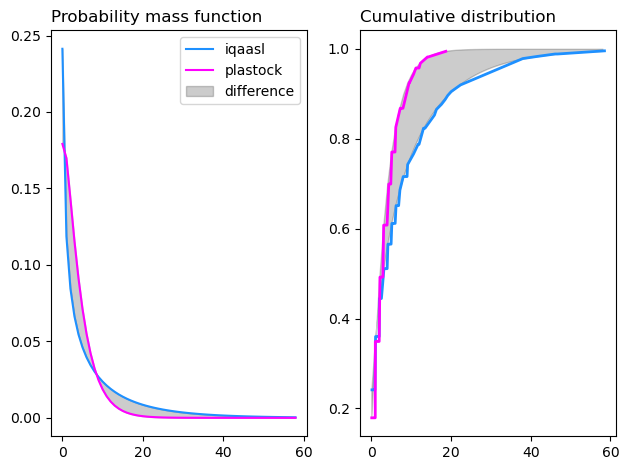

In [11]:
from scipy.stats import nbinom
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

e_pstock = combined_dt[combined_dt.project == "plastock"]
x_p = e_pstock["pcs/m"].sort_values()
ecdf_pstock = ecdf(x_p)

e_iqaasl = combined_dt[combined_dt.project == "iqaasl"]
x_i = e_iqaasl["pcs/m"].sort_values()
ecdf_iqaasl = ecdf(x_i)

def make_n(mean, variance):
    return mean**2/(variance-mean)
def make_p(mean, variance):
    return mean/variance

n_i = make_n(np.mean(x_i), np.var(x_i))
p_i = make_p(np.mean(x_i), np.var(x_i))

n_p = make_n(np.mean(x_p), np.var(x_p))
p_p = make_p(np.mean(x_p), np.var(x_p))

x_ii = np.arange(0, x_i.max())
x_pi = np.arange(0,  x_i.max())

i_nb = nbinom(n_i, p_i)
p_nb = nbinom(n_p, p_p)

fig, ax = plt.subplots(1,2)
ax[0].plot(x_ii, i_nb.pmf(x_ii), label='iqaasl', c='dodgerblue')
ax[0].plot(x_pi, p_nb.pmf(x_pi), label='plastock', c='magenta')
ax[0].fill_between(x_pi,p_nb.pmf(x_pi), i_nb.pmf(x_ii), alpha=0.2, color="black", label="difference")
ax[0].legend()
ax[0].set_title("Probability mass function", loc="left")
ax[1].fill_between(x_pi,p_nb.cdf(x_pi), i_nb.cdf(x_pi), alpha=0.2, color="black", label="difference")
ax[1].plot(x_i, i_nb.cdf(x_i), color="dodgerblue", linewidth=2)
ax[1].plot(x_p, p_nb.cdf(x_p), color="magenta", linewidth=2)
ax[1].set_title("Cumulative distribution", loc="left")
plt.tight_layout()

plt.show()

### Quantifying the difference

To quantify the difference between the two sampling periods we will consider the following:

1. The probability that samples from one period could have been drawn from the other
2. Comparing the 90% confidence interval of the two distributions
3. Visully comparing the results in a box-plot

#### The confidence intervals and boxplots

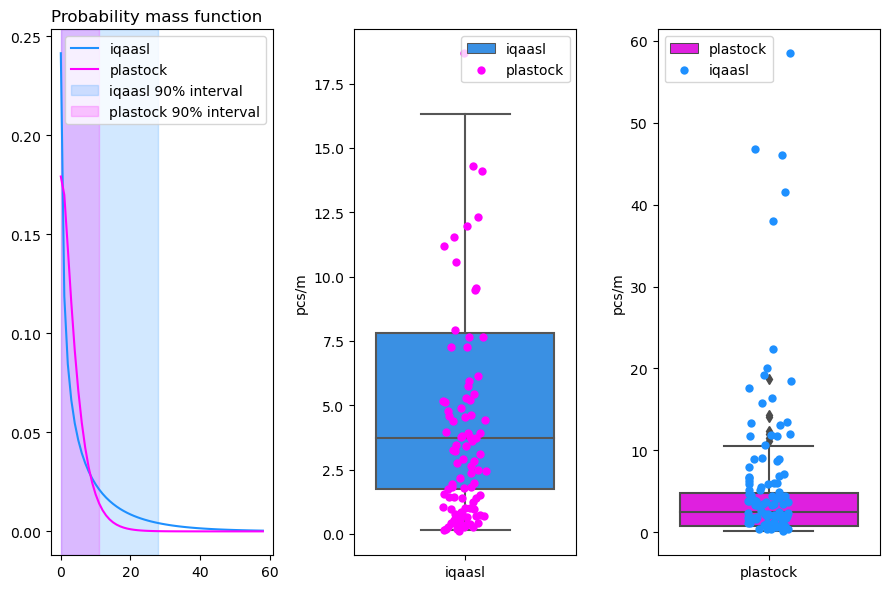

In [12]:
i_nbci = i_nb.interval(.9)
p_nbci = p_nb.interval(.9)

fig, ax = plt.subplots(1,3, figsize=(9,6))
ax[0].plot(x_ii, i_nb.pmf(x_ii), label='iqaasl', c='dodgerblue')
ax[0].plot(x_pi, p_nb.pmf(x_pi), label='plastock', c='magenta')
ax[0].axvspan(xmin=i_nbci[0], xmax=i_nbci[1], color="dodgerblue", alpha=0.2, label="iqaasl 90% interval")
ax[0].axvspan(xmin=p_nbci[0], xmax=p_nbci[1], color="magenta", alpha=0.2, label="plastock 90% interval")
# ax[0].fill_between(x_pi,p_nb.pmf(x_pi), i_nb.pmf(x_ii), alpha=0.2, color="black", label="difference")
ax[0].legend()
ax[0].set_title("Probability mass function", loc="left")

sns.boxplot(data=combined_dt[combined_dt.project == "iqaasl"], y="pcs/m", x="project", ax=ax[1], hue="project", palette=palette, showfliers=False, dodge=False)
sns.stripplot(data=combined_dt[combined_dt.project == "plastock"],  x="project", y="pcs/m", ax=ax[1], color="magenta", size=6, dodge=True, label="plastock")
ax[1].set_xlabel("")
sns.boxplot(data=combined_dt[combined_dt.project == "plastock"], y="pcs/m", x="project", ax=ax[2], hue="project", palette=palette, showfliers=True, dodge=False)
sns.stripplot(data=combined_dt[combined_dt.project == "iqaasl"],  x="project", y="pcs/m", ax=ax[2], color="dodgerblue", size=6, dodge=True, label="iqaasl")
ax[2].set_xlabel("")

plt.tight_layout()

plt.show()

__Interpretation:__

1. The 90% interval from the plastock samples fall within the 90% interval of IQAASL
2. 99% of all samples from plastock fall within the 90% interval of iqaasl
3. 80% of all samples from iqaasl fall within the 90% interval of plastock

__Remarks:__ The standard deviation of iqaasl is $\approx$ 3 times that of plastock. There are more sampling days in iqaasl v/s plastock.

In [13]:
iq_in_pstockci = [x for x in x_i if x <= p_nbci[1]]
p_iq_inp = len(iq_in_pstockci)/len(x_i)
p_iq_inp

0.8061224489795918

In [14]:
pnames = combined[combined.project == "plastock"].copy()
iqnames = combined[combined.project == "iqaasl"].copy()



pnames["city"] = pnames.location

city_names = {
    "Grangettes":"Villeneuve",
    "Port Choilseul": "Versoix",
    "Pichette": "Vevey"
}



def change_names(x, names=city_names.keys(), city_names=city_names):
    
    if x in names:
        x = city_names[x]
    
    return x

pnames["city"] = pnames.location.apply(lambda x: change_names(x))


iqcities = iqaasl[['location', 'city']].drop_duplicates(['location', 'city']).set_index('location')
iqnames["city"] = iqnames.location.apply(lambda x: iqcities["city"].loc[x])


city_combined = pd.concat([iqnames, pnames])


In [15]:
pnames_s = p_beaches.location.unique()

pnames_s


array(['Amphion', 'Anthy', 'Excenevex', 'Lugrin', 'Meillerie',
       'Saint-Disdille', 'Tougues', 'Baby Plage', 'Hermance',
       'Port Choiseul', 'Savonière', 'Versoix', 'Aubonne', 'Clarens',
       'Crans', 'Cully', 'Gland', 'Grangettes', 'Lutry', 'Pichette',
       'Préverenges', 'Rolle', 'Tolochenaz', 'Vidy', 'Bouveret'],
      dtype=object)

In [16]:
# fail rate
def n_fails(data, code, threshhold=0):
    
    return ((data.code == code) & (data.quantity > threshhold)).sum()    

def fail_rate(data, code, threshhold=0, project="iqaasl"):
    d = data[data.project == project]
    fails = n_fails(d, code, threshhold=threshhold)
    tries = d.loc_date.nunique()
    
    return fails/tries

def make_fail_rate_df(data, codes, project="iqaasl", threshold=0):
    
    results = []
    
    for code in codes:
        results.append({"code":code, "project":project, "fail rate":fail_rate(data, code, project=project)})
    
    return pd.DataFrame(results)

iqa_fail_rate = make_fail_rate_df(combined, codes)
pstk_fail_rate = make_fail_rate_df(combined, codes, project='plastock')

fail_rates = pd.concat([iqa_fail_rate, pstk_fail_rate], axis=0)

fail_rates = fail_rates.pivot(index="code", columns="project")
fail_rates.sort_values(by=("fail rate","iqaasl"), ascending=False)[:20]

fail rate          
project    iqaasl  plastock
code                       
Gfrags   0.969388  0.968421
G30      0.959184  0.736842
G27      0.948980  0.800000
Gfoam    0.836735  0.736842
G95      0.816327  0.547368
G74      0.775510  0.378947
G67      0.775510  0.084211
G35      0.734694  0.410526
G89      0.663265  0.315789
G31      0.663265  0.557895
G32      0.632653  0.242105
G100     0.612245  0.094737
G33      0.571429  0.178947
G25      0.551020  0.042105
G70      0.520408  0.400000
G10      0.510204  0.094737
G112     0.469388  0.368421
G211     0.438776  0.410526
G66      0.418367  0.305263
G73      0.397959  0.063158